In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

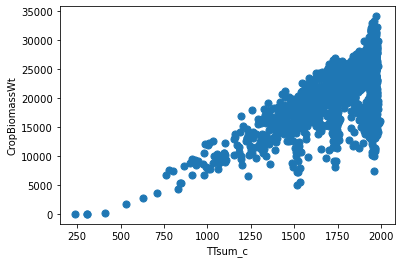

In [3]:
maize_data = pd.read_csv('../data/maize.csv')
maize_data.plot.scatter(x='TTsum_c', y='CropBiomassWt', s=50);

In [5]:
x, y = maize_data[['TTsum_c', 'CropBiomassWt']].values.T

In [38]:
x

array([ 975.538, 1030.011,  760.74 , ..., 1958.573, 1962.019, 1958.748])

In [39]:
maize_data.TTsum_c.values.reshape(-1,1)

array([[ 975.538],
       [1030.011],
       [ 760.74 ],
       ...,
       [1958.573],
       [1962.019],
       [1958.748]])

## Gaussian Process

In [8]:
with pm.Model() as gp_maize_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=(maize_data.CropBiomassWt/maize_data.TTsum_c).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    Xu = pm.gp.util.kmeans_inducing_points(10, x.reshape(-1,1))
    
    σ = pm.HalfNormal('σ', 50)
    
    yield_gp = pm.gp.MarginalSparse(mean_func=M, cov_func=K, approx="FITC")
    yield_gp.marginal_likelihood('CropBiomassWt', X=x.reshape(-1,1), Xu=Xu, y=y, noise=σ)
    

In [9]:
with gp_maize_model:
    gp_trace = pm.sample(1000, tune=2000, cores=1, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, η, ρ]


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `ρ_log__`.ravel()[0] is zero.

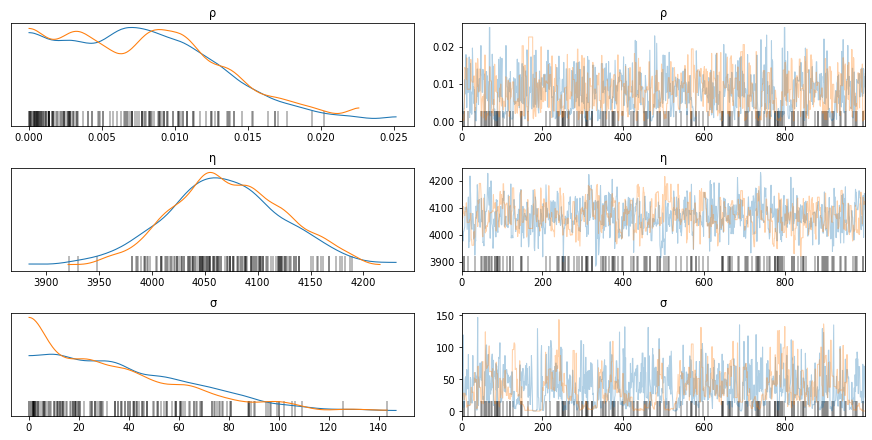

In [51]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [53]:
X_pred = np.linspace(250, 2000, 100)

with gp_maize_model:
    maize_pred = recruit_gp.conditional("maize_pred", X_pred.reshape(-1, 1))
    gp_maize_samples = pm.sample_posterior_predictive(gp_trace, vars=[maize_pred], samples=3, random_seed=42)

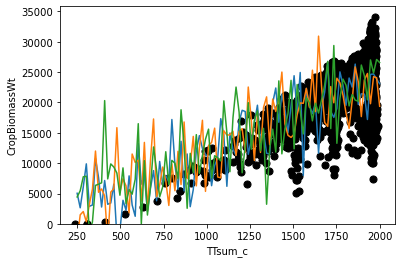

In [55]:
ax = maize_data.plot.scatter(x='TTsum_c', y='CropBiomassWt', c='k', s=50)
ax.set_ylim(0, None)
for x in gp_maize_samples['maize_pred']:
    ax.plot(X_pred, x);

In [64]:
with gp_maize_model:
    gp_maize_samples = pm.sample_posterior_predictive(gp_trace, vars=[maize_pred], samples=100, random_seed=42)

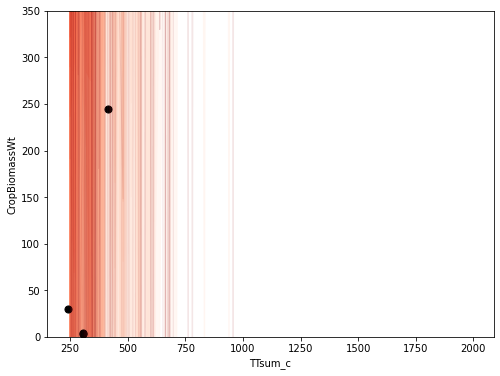

In [65]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_maize_samples['maize_pred'], X_pred)
maize_data.plot.scatter(x='TTsum_c', y='CropBiomassWt', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);

In [ ]:
with gp_maize_model:
    maize_pred_noise = recruit_gp.conditional("maize_pred_noise", X_pred.reshape(-1,1), pred_noise=True)
    gp_maize_samples = pm.sample_posterior_predictive(gp_trace, vars=[maize_pred_noise], samples=500, random_seed=42)

In [ ]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_maize_samples['maize_pred_noise'], X_pred)
maize_data.plot.scatter(x='TTsum_c', y='CropBiomassWt', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);

### Exercise

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed. Generate predictions from the posterior predictive distribution that covers this range of spawners.

*Hint: you need to add a new `conditional` variable.*

In [ ]:
# Write answer here